In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import pytz

import matplotlib as mpl
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from hamsci_psws import geopack, grape1
%matplotlib inline

Re = 6371 # Radius of the Earth in km

In [3]:
mpl.rcParams['font.size']      = 12
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = np.array([15, 8])
mpl.rcParams['axes.xmargin']   = 0

## Define Station Locations

In [4]:
tx = {}
tx['st_id'] = 'WWV'
tx['lat']   =  40.68
tx['lon']   = -105.04

In [5]:
freq            = 10e6 # MHz
sTime           = datetime.datetime(2021,10,28,12, tzinfo=pytz.UTC)
eTime           = datetime.datetime(2021,10,28,18, tzinfo=pytz.UTC)

inventory = grape1.DataInventory()
inventory       = grape1.DataInventory()
inventory.filter(sTime=sTime,eTime=eTime)
grape_nodes     = grape1.GrapeNodes(logged_nodes=inventory.logged_nodes)

grapes = grape_nodes.nodes_df

grapes['lat'] = grapes.Latitude
grapes['lon'] = grapes.Longitude

In [6]:
# grapes = []

# g = {}
# g['st_id'] = 'kd2uhn'
# g['lat']   =  40.6332
# g['lon']   = -74.98881
# g['color'] = 'purple'
# grapes.append(g)

# g = {}
# g['st_id'] = 'n2rkl'
# g['lat']   =  43.16319
# g['lon']   = -76.12535
# g['color'] = 'green'
# grapes.append(g)

# g = {}
# g['st_id'] = 'n8obj'
# g['lat']   =  41.321963
# g['lon']   = -81.504739
# g['color'] = 'cyan'
# grapes.append(g)

# grapes = pd.DataFrame(grapes)
# grapes = grapes.set_index('st_id')
# grapes

## Calculate midpoints between Transmitter and Receivers

In [7]:
# colormapping:
cmap = mpl.cm.get_cmap('viridis')
color_dct   = {'ckey':'lon'}
norm = mpl.colors.Normalize(vmin=-130, vmax=-60)
mpbl = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

In [8]:
grapes



rgba = cmap(0.5)
print(rgba) # (0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0)

grapes_new = []
for rinx, row in grapes.iterrows():
    # print(rinx)
    lat = row['Latitude']
    lon = row['Longitude']
    
    
    azm = geopack.greatCircleAzm(tx['lat'],tx['lon'],lat,lon)
    rng = geopack.greatCircleDist(tx['lat'],tx['lon'],lat,lon)*Re
    res = geopack.greatCircleMove(tx['lat'],tx['lon'],rng/2.,azm,alt=0,Re=Re)
    
    row['mid_lat'] = res[0][0]
    row['mid_lon'] = res[1][0]
    # row['color'] = 'purple'
    row['color'] = mpbl.cmap(mpbl.norm(lon))#cmap(lon/20)
    
    grapes_new.append(row)
    
grapes = pd.DataFrame(grapes_new)
grapes = grapes.set_index('Callsign')
# grapes

(0.127568, 0.566949, 0.550556, 1.0)


## Load Eclipse Data

## Plot on a Map

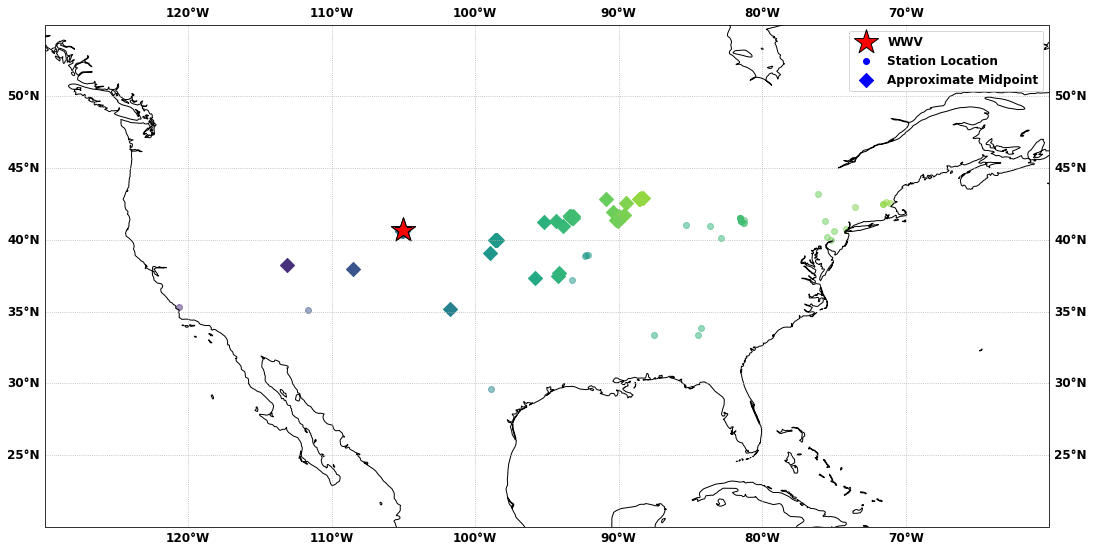

In [16]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax  = fig.add_subplot(1,1,1,projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)

# for ecl_year,ecl_dict in eclipses.items():
#     ecl      = ecl_dict['ecl_data']
#     obsc_min = ecl_dict.get('obsc_min',0)
#     alpha     = ecl_dict.get('alpha',0.65)
#     cmap     = ecl_dict.get('cmap',mpl.cm.gray_r)
#     lats     = ecl.lats
#     lons     = ecl.lons
#     obsc_arr = ecl.get_obsc_arr(obsc_min=obsc_min)
#     pcoll    = ax.pcolormesh(lons,lats,obsc_arr,vmin=0,vmax=1,cmap=cmap,zorder=1,alpha=alpha)

alpha = 0.5

# Plot Ground Locations of Grapes
for rinx,row in grapes.iterrows():
    lat   = row['lat']
    lon   = row['lon']
    label = rinx.upper()
    color = row['color']
    ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],alpha=alpha)
    
# Plot Grape Midpoints
for rinx,row in grapes.iterrows():
    lat   = row['mid_lat']
    lon   = row['mid_lon']
    label = '{!s} Midpoint'.format(rinx.upper())
    color = row['color']
    # print(color)

    ax.scatter([lon],[lat],label=label,c=[color],marker='D',s=100)
    # ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],marker='D',s=100)
# Plot Transmitter
ax.scatter(tx['lon'],tx['lat'],marker='*',s=650,color='r',label=tx['st_id'],ec='black')

# ax.legend(loc='lower right',fontsize='large')

# # LEGEND TESTING:
# x = list(range(10))
# y = [i + 1 for i in x]  
scat1 = plt.scatter(0, 0)
# # scat2 = plt.scatter(tx['lon'],tx['lat'],marker='*',s=650,color='r',label=tx['st_id'],ec='black')
ax.legend([scat1],['Station Locations'], loc='lower right',fontsize='large')

wwv = ax.scatter(tx['lon'],tx['lat'],marker='*',s=650,color='r',label=tx['st_id'],ec='black')
station = ax.scatter(0, 0, color='b',label='Station Location')
midpoint = ax.scatter(0, 0, marker='D',s=100,color='b',label='Approximate Midpoint')
ax.legend(handles=[wwv, station, midpoint])

    
# # World Limits
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)

# US Limits
ax.set_xlim(-130,-60)
ax.set_ylim(20,55)

plt.savefig('output/map.png')
plt.show()
